# Práctica 4 - Clasificación

Nombres:
* Sergio de la Cruz
...

En esta práctica, tendréis que predecir la concesión de créditos de un banco. Tenéis los datasets abajo igual que en la práctica anterior.

Esta vez, obligaremos a subir una submission a la competición de kaggle, con premio especial para:
* Los ganadores de la competición
* Todo aquel que supere la precisión obtenida por los mentores

Podéis encontrar la URL de kaggle (donde se encuentran, entre otras cosas, los criterios de evaluación) aquí:
https://www.kaggle.com/t/9c6fa1489e714d45889b013bd2abd267

Suerte!

In [1]:
train_url = "https://gist.githubusercontent.com/w-dan/5b1d67c4f507b2b826ed90bec372f1a4/raw/24679757c6bf9bcc74ef4d7944196a1f37b93eba/train3.csv"
test_url = "https://gist.githubusercontent.com/w-dan/5b1d67c4f507b2b826ed90bec372f1a4/raw/24679757c6bf9bcc74ef4d7944196a1f37b93eba/test3.csv"

Un consejo para las submissions:

Guardad la columna `ID` al principio, así podéis droppear sin riesgos


```python
df_test = pd.read_csv(test_url)
submission = df_test[['ID']].copy()      # preparamos un dataframe con una columna 'ID'
```


Y ahora, para montar la submission:

```python
mis_predicciones = mi_clasificador.predict(df_test)

# al final del ejercicio, guardamos las predicciones en el dataframe 'submission' que creamos al principio
submission['Credit_Score'] = y_pred_dftest

# si habéis cambiado a números (algunos algoritmos lo requieren) la variable objetivo, revertid los cambios, por ejemplo, asi:
submission.Credit_Score = submission.Credit_Score.replace({0: "Poor", 1: "Standard", 2: "Good"})

```

Para guardarla como csv y subirla a kaggle:

```python
submission.to_csv("./mi_submission.csv", index=False)

# o si usáis google colab, os dejo una forma cómoda de descargar el csv:
from google.colab import files
submission.to_csv('mi_submission.csv', index=False)
files.download('mi_submission.csv')
```

Y directos a la cima del ranking :D


¡Mucha suerte!

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
import re

In [3]:
train_df = pd.read_csv(train_url)
test_df = pd.read_csv(test_url)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
train_df.head(4)

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,Num_of_Loan,Type_of_Loan,Delay_from_due_date,Num_of_Delayed_Payment,Changed_Credit_Limit,Num_Credit_Inquiries,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,43161,3985,4,Lawrencez,40.0,856431180.0,Accountant,97384.44,8167.370000,1.0,3.0,8.0,1.0,Debt Consolidation Loan,20.0,12.0,0.52,3.0,Good,405.45,32.643281,336.0,No,77.284943,53.714219,High_spent_Large_value_payments,847.172909,Standard
1,40663,49494,2,Mohammedr,39.0,417453942.0,Writer,31369.58,2607.131667,8.0,9.0,27.0,8.0,"Home Equity Loan, Not Specified, Not Specified...",30.0,25.0,19.70,6.0,Bad,4259.91,39.375507,144.0,Yes,171.748418,44.990811,High_spent_Large_value_payments,280.855383,Standard
2,111059,2925,6,Alistairn,17.0,499528888.0,Writer,30171.86,2772.321667,6.0,7.0,30.0,9.0,"Personal Loan, Home Equity Loan, Home Equity L...",49.0,18.0,23.49,10.0,Bad,3406.51,34.039021,123.0,Yes,205.403926,40.781489,High_spent_Large_value_payments,247.322615,Standard
3,72139,21358,2,Dinesh Naire,22.0,859449371.0,Doctor,13100.02,1246.668333,7.0,5.0,6.0,5.0,"Credit-Builder Loan, Credit-Builder Loan, Not ...",6.0,20.0,10.64,8.0,Standard,727.29,34.747262,129.0,Yes,41.177132,23.005463,Low_spent_Large_value_payments,298.156832,Standard


65000


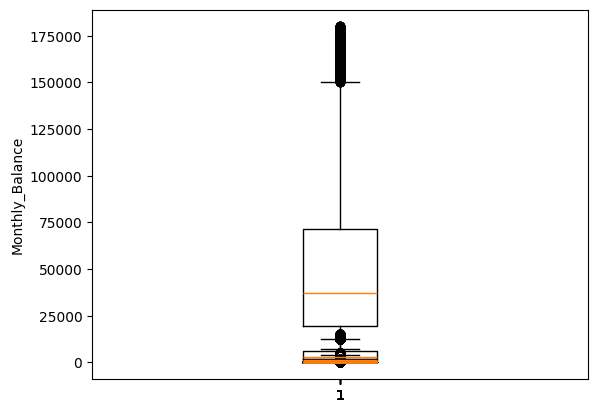

In [7]:
print(train_df.shape[0])
for col in ['Month', 'Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
             'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment',
               'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 
               'Credit_History_Age', 'Total_EMI_per_month',	'Amount_invested_monthly',	'Monthly_Balance']:# Crear la gráfica de puntos
    plt.boxplot(train_df[col])

    # Agregar etiquetas y título
    plt.ylabel(col)
    # Mostrar la gráfica
    # plt.show()

In [8]:
print(train_df.shape[0])
# train_df[train_df.Customer_ID==1011]
print(train_df[['Customer_ID', 'Credit_Score']].drop_duplicates().shape[0])
print(train_df[['ID', 'Credit_Score']].drop_duplicates().shape[0])

65000
18619
65000


Se puntuan a las cuentas bancarias no a las personas

In [40]:
def onehot_encode(train_df, columns_to_encode):
    # columns_to_encode = ['fuel', 'seller_type', 'owner', 'marca', 'transmission']
    for column in columns_to_encode:
        encoder = OneHotEncoder()
        encoded = encoder.fit_transform(train_df[[column]])
        encoded_df = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out([column]))
        encoded_df = encoded_df.astype(int)
        train_df = pd.concat([train_df, encoded_df], axis=1)
    return train_df
    # train_df[['engine','RPM','transmission', 'fuel_encode', 'seller_type_encode', 'owner_encode',	'marca_encode']] =train_df[['engine','RPM','transmission_encode', 'fuel_encode', 'seller_type_encode', 'owner_encode',	'marca_encode']].astype(int)
    
def ordinal_encode(train_df, columns_to_encode, encode):
    if encode == None:
            encoder = OrdinalEncoder()
    for column in columns_to_encode:
        if encode != None:
            cat = encode.get(column)
            encoder = OrdinalEncoder(categories=[cat])
        train_df[column+'_encode'] = encoder.fit_transform(train_df[[column]])
        train_df[column+'_encode'] = train_df[column+'_encode'].astype(int)
    return train_df

def type_loan_encode(row):
    loans = row['Type_of_Loan'].replace(' and', '').replace(' ', '_').split(',_')
    for loan in loans:
        row[loan] = 1
    return row

def payment_behaviour_encode(row):
    PB = row['Payment_Behaviour'].split('_')
    row['Payment_Behaviour_spent'] = PB[0]
    row['Payment_Behaviour_value_payments'] = PB[2]
    return row

def encode_rows(row):
    row = payment_behaviour_encode(row)
    row = type_loan_encode(row)
    return row


def preproceso(train_df, encode):

    train_df = train_df.drop_duplicates()
    train_df = train_df.dropna().reset_index(drop=True)
    train_df = train_df.apply(lambda x: encode_rows(x), axis=1)
    for col in train_df.columns:
        if col.find('_Loan')!=-1:
            train_df[col] = train_df[col].fillna(0)
    train_df['Not_Specified'] = train_df['Not_Specified'].fillna(0)
    train_df['No_Data'] = train_df['No_Data'].fillna(0)
    
    train_df.Credit_Mix = train_df.Credit_Mix.replace({"Standard": 0, "Bad": 1, "Good": 2})
    train_df.Credit_Score = train_df.Credit_Score.replace({"Standard": 0, "Poor": 1, "Good": 2})
    train_df.Payment_Behaviour_spent = train_df.Payment_Behaviour_spent.replace({"High": 0, "Low": 1})
    train_df.Payment_Behaviour_value_payments = train_df.Payment_Behaviour_value_payments.replace({"Medium": 0, "Large": 1, "Small": 2})
    train_df.Payment_of_Min_Amount = train_df.Payment_of_Min_Amount.replace({"NM": 0, "No": 1, "Yes":2})
    # columns_to_encode = ['Credit_Mix',	'Credit_Score', 'Occupation', 'Payment_Behaviour_spent', 'Payment_Behaviour_value_payments', 'Payment_of_Min_Amount']
    # train_df = onehot_encode(train_df, ['Occupation'])


    train_df = train_df.drop(['Name', 'Type_of_Loan', 'Payment_Behaviour', 'Occupation', 'SSN'], axis=1)

    return train_df

new_train_df = preproceso(train_df, None)


In [41]:
new_train_df

,Age,Amount_invested_monthly,Annual_Income,Auto_Loan,Changed_Credit_Limit,Credit-Builder_Loan,Credit_History_Age,Credit_Mix,Credit_Score,Credit_Utilization_Ratio,Customer_ID,Debt_Consolidation_Loan,Delay_from_due_date,Home_Equity_Loan,ID,Interest_Rate,Month,Monthly_Balance,Monthly_Inhand_Salary,Mortgage_Loan,No_Data,Not_Specified,Num_Bank_Accounts,Num_Credit_Card,Num_Credit_Inquiries,Num_of_Delayed_Payment,Num_of_Loan,Outstanding_Debt,Payday_Loan,Payment_Behaviour_spent,Payment_Behaviour_value_payments,Payment_of_Min_Amount,Personal_Loan,SSN,Student_Loan,Total_EMI_per_month
0,40.0,53.714219,97384.440,0.0,0.52,0.0,336.0,2,0,32.643281,3985,1.0,20.0,0.0,43161,8.0,4,847.172909,8167.370000,0.0,0.0,0.0,1.0,3.0,3.0,12.0,1.0,405.45,0.0,0,1,1,0.0,856431180.0,0.0,77.284943
1,39.0,44.990811,31369.580,0.0,19.70,0.0,144.0,1,0,39.375507,49494,0.0,30.0,1.0,40663,27.0,2,280.855383,2607.131667,1.0,0.0,1.0,8.0,9.0,6.0,25.0,8.0,4259.91,0.0,0,1,2,1.0,417453942.0,0.0,171.748418
2,17.0,40.781489,30171.860,0.0,23.49,1.0,123.0,1,0,34.039021,2925,0.0,49.0,1.0,111059,30.0,6,247.322615,2772.321667,1.0,0.0,0.0,6.0,7.0,10.0,18.0,9.0,3406.51,0.0,0,1,2,1.0,499528888.0,1.0,205.403926
3,22.0,23.005463,13100.020,0.0,10.64,1.0,129.0,0,0,34.747262,21358,1.0,6.0,1.0,72139,6.0,2,298.156832,1246.668333,0.0,0.0,1.0,7.0,5.0,8.0,20.0,5.0,727.29,0.0,1,1,2,0.0,859449371.0,0.0,41.177132
4,26.0,63.346750,62313.540,1.0,12.82,1.0,122.0,0,0,24.545394,21221,0.0,27.0,0.0,119841,18.0,4,152.669902,5120.795000,0.0,0.0,0.0,6.0,2.0,9.0,8.0,4.0,817.64,1.0,1,0,0,0.0,485239890.0,1.0,196.679642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64995,44.0,43.165679,19795.890,0.0,14.71,0.0,324.0,0,2,27.049585,35996,1.0,24.0,0.0,22570,12.0,5,286.771047,1203.188188,0.0,0.0,0.0,3.0,3.0,2.0,17.0,1.0,582.75,0.0,1,1,2,0.0,863986928.0,0.0,159.609395
64996,23.0,32.825775,33624.400,1.0,8.80,0.0,348.0,0,0,38.337145,15146,0.0,30.0,1.0,134156,20.0,3,421.253518,2869.033333,1.0,0.0,0.0,4.0,5.0,7.0,9.0,4.0,987.27,0.0,0,1,0,1.0,2121646.0,0.0,72.257138
64997,15.0,26.005337,17057.830,1.0,20.72,1.0,60.0,1,1,36.584023,8722,1.0,26.0,0.0,145951,24.0,2,238.070938,1618.485833,1.0,0.0,0.0,6.0,10.0,10.0,20.0,6.0,4832.80,0.0,1,0,2,0.0,787947051.0,1.0,65.827966
64998,18.0,168.868471,125385.880,0.0,9.36,0.0,296.0,2,0,38.854570,24372,1.0,17.0,0.0,27919,5.0,2,437.879559,10720.823333,1.0,0.0,1.0,2.0,5.0,1.0,1.0,4.0,1268.57,0.0,0,2,0,1.0,432941541.0,0.0,364.360310


In [84]:
# columnas_disc.append('km_driven')

for col in new_train_df.columns.difference(['Name', 'Type_of_Loan', 'Occupation', 'SSN', 'Credit_Score']):# Crear la gráfica de puntos
    print(new_train_df[col].mean(axis=0))
    print(new_train_df[[col, 'Credit_Score']].groupby('Credit_Score').mean(),'\n')
    print(new_train_df[[col, 'Credit_Score']].groupby(col).count(),'\n')
    
    # plt.figure(figsize=[2,2])
    # plt.scatter(train_df['Credit_Score'], train_df[col])

    # # Agregar etiquetas y título
    # plt.xlabel('Credit_Score')
    # plt.ylabel(col)
    # # Mostrar la gráfica
    # plt.show()

33.33293846153846
                    Age
Credit_Score           
0             33.453663
1             31.236852
2             36.382654 

      Credit_Score
Age               
14.0           792
15.0          1074
16.0           978
17.0           990
18.0          1543
19.0          1903
20.0          1812
21.0          1828
22.0          1858
23.0          1744
24.0          1784
25.0          1889
26.0          1968
27.0          1915
28.0          1966
29.0          1869
30.0          1851
31.0          2010
32.0          1929
33.0          1720
34.0          1854
35.0          1924
36.0          1922
37.0          1840
38.0          1996
39.0          1903
40.0          1770
41.0          1846
42.0          1739
43.0          1832
44.0          1888
45.0          1733
46.0          1075
47.0           858
48.0           931
49.0           902
50.0           854
51.0           876
52.0           886
53.0           871
54.0           900
55.0           928
56.0           249 

55.

In [42]:
from sklearn import metrics

def evalua(y_test, data_pred):
    print("Accuracy:", metrics.accuracy_score(y_test, data_pred))
    print("F1:", metrics.f1_score(y_test, data_pred, average='weighted'))
    cm =  metrics.confusion_matrix(y_test, data_pred)
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,)
    disp.plot()
    plt.show()

In [43]:
from sklearn.tree import DecisionTreeClassifier

n_fit=int(train_df.shape[0]*0.9)

X_train = new_train_df[new_train_df.columns.drop('Credit_Score')][:n_fit]
y_train = new_train_df['Credit_Score'][:n_fit]

arbol = DecisionTreeClassifier(criterion='entropy', splitter='random', random_state=42)
arbol = arbol.fit(X_train,y_train)

Accuracy: 0.7163076923076923
F1: 0.7163579485366011


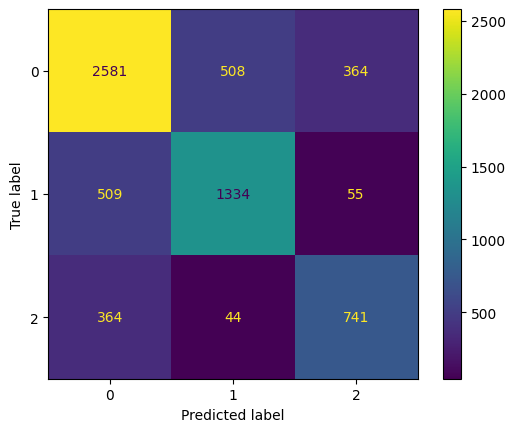

In [50]:

X_test = new_train_df[new_train_df.columns.drop('Credit_Score')][n_fit:]
y_test = new_train_df['Credit_Score'][n_fit:]
# X_test = X_test[X_test.columns.drop('Credit_Score')]
data_pred = arbol.predict(X_test)

evalua(y_test, data_pred)

Accuracy: 0.7526153846153846
F1: 0.7517703130722792


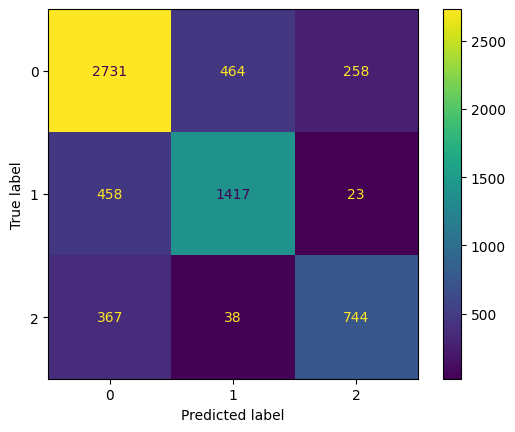

In [51]:
from sklearn.neighbors import KNeighborsClassifier

X_test = new_train_df[new_train_df.columns.drop('Credit_Score')][n_fit:]
y_test = new_train_df['Credit_Score'][n_fit:]
# X_test = X_test[X_test.columns.drop('Credit_Score')]

classifier = KNeighborsClassifier().fit(X_train,y_train)
data_pred = classifier.predict(X_test)

evalua(y_test, data_pred)


Probar XGBoost

In [52]:
# from six import StringIO 
# from sklearn.tree import export_graphviz
# import pydotplus
# from IPython.display import Image  

# dot_data = StringIO()
# export_graphviz(arbol, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True)
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# Image(graph.create_png())